<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Third%20Graded%20Assignment/GA3_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GA3 Model 2 - Using history window of pollution
Then you make a second baseline that uses only current pollution and pollution history, so a single timeseries: a window-based dense network (the window size is an important hyperparameter to explore here). This baseline should at least outperform the simplest baseline.



## Imports and drive mounting

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading preprocessed data

In [3]:
DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/DL2021/'  
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

## Selecting the features (only pollution history)

In [4]:
features = [4]
pollution = 4

train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 1)
(26280,)
(8760, 1)
(8760,)
(35040, 1)
(35040,)
(8760, 1)
(8760,)


In [5]:
# Scale the features 
# Look up and choose a scaler
# StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

# Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.

SS1 = RobustScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = RobustScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

## Construct a very basic baseline (current = prediction)

In [6]:
# dense network:
# here you only need to take into account that we are predicting 3 steps ahead
# this means that the features of the first timestep (index 0)
# are used to predict the 4th pollution value (index 3) so the first 3 and the last 3 feature-samples labels are omitted

def create_dataset_dense(train, test, ahead=3):   # can use this with different 'ahead' values, but default is set to 3
    return train[:-ahead,:], test[ahead:]

X_train_d,r_train_d = create_dataset_dense(train_scaled,train_labels)
X_val_d,r_val_d = create_dataset_dense(val_scaled,val_labels)

X_train_all_d,r_train_all_d = create_dataset_dense(train_all_scaled,train_all_labels)
X_test_d,r_test_d = create_dataset_dense(test_scaled,test_labels)


print(X_train_d.shape)
print(r_train_d.shape)

(26277, 1)
(26277,)


In [7]:
# We use current pollution as prediction for the "dense" labels


from sklearn.metrics import mean_absolute_error
y_train_current = train_values[:-3,0]
y_val_current = val_values[:-3,0]
y_test_current = test_values[:-3,0]

mae_train_current = mean_absolute_error(r_train_d,y_train_current)
mae_val_current = mean_absolute_error(r_val_d,y_val_current)
mae_test_current = mean_absolute_error(r_test_d,y_test_current)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_current,
      "\n validation mae = ",mae_val_current,
      "\n test mae = ",mae_test_current)

"Current pollution" baseline:
 train mae =  26.28013 
 validation mae =  28.706179 
 test mae =  26.04659


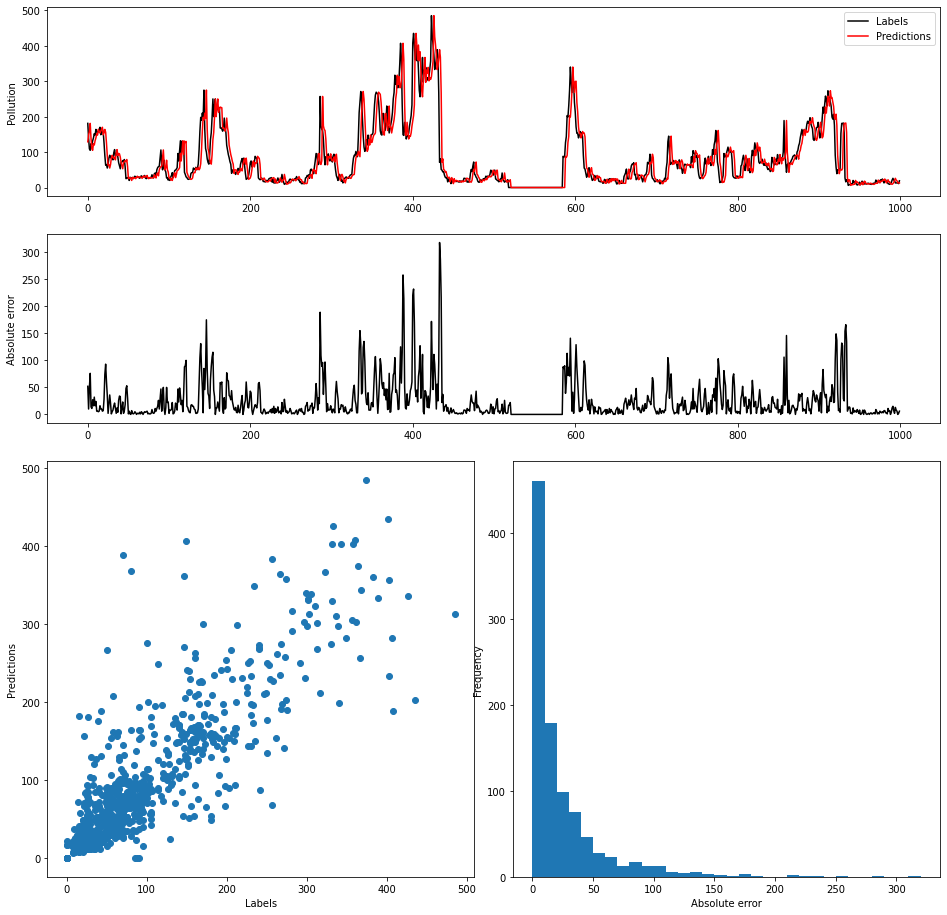

In [8]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

# Visualise first 1000 predictions
PlotResults(r_train_d[:1000],y_train_current[:1000])

## Make a windowed model


In [9]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]


In [10]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

In [42]:
CNN_WINDOW_SIZE = 5
# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features

# note that in the current feature set, pollution is the first feature (index=0)

train_features = [0,] 

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=CNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=CNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=CNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=CNN_WINDOW_SIZE)


CNNmodel = Sequential()
CNNmodel.add(Dense(64, input_shape = (CNN_WINDOW_SIZE, X_train_w.shape[-1]), activation='relu'))
CNNmodel.add(Dense(32, activation='relu'))
CNNmodel.add(Dense(8, activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(1))
CNNmodel.add(Activation('linear'))

CNNmodel.summary()

CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae', metrics=['mae','mse'])

batch_size=64
epochs=30
CNN_history = CNNmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 5, 64)             128       
_________________________________________________________________
dense_79 (Dense)             (None, 5, 32)             2080      
_________________________________________________________________
dense_80 (Dense)             (None, 5, 8)              264       
_________________________________________________________________
flatten_18 (Flatten)         (None, 40)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 41        
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total params: 2,513
Trainable params: 2,513
Non-trainable params: 0
___________________________________________________

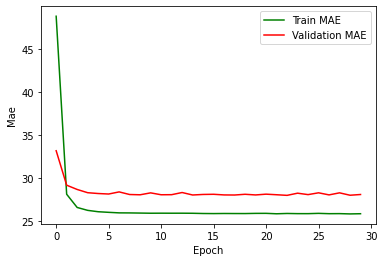

In [43]:
plot_history(CNN_history)

"Window pollution" baseline:
 train mae =  25.989393 
 validation mae =  28.063368
(26273, 1)
(8753, 1)


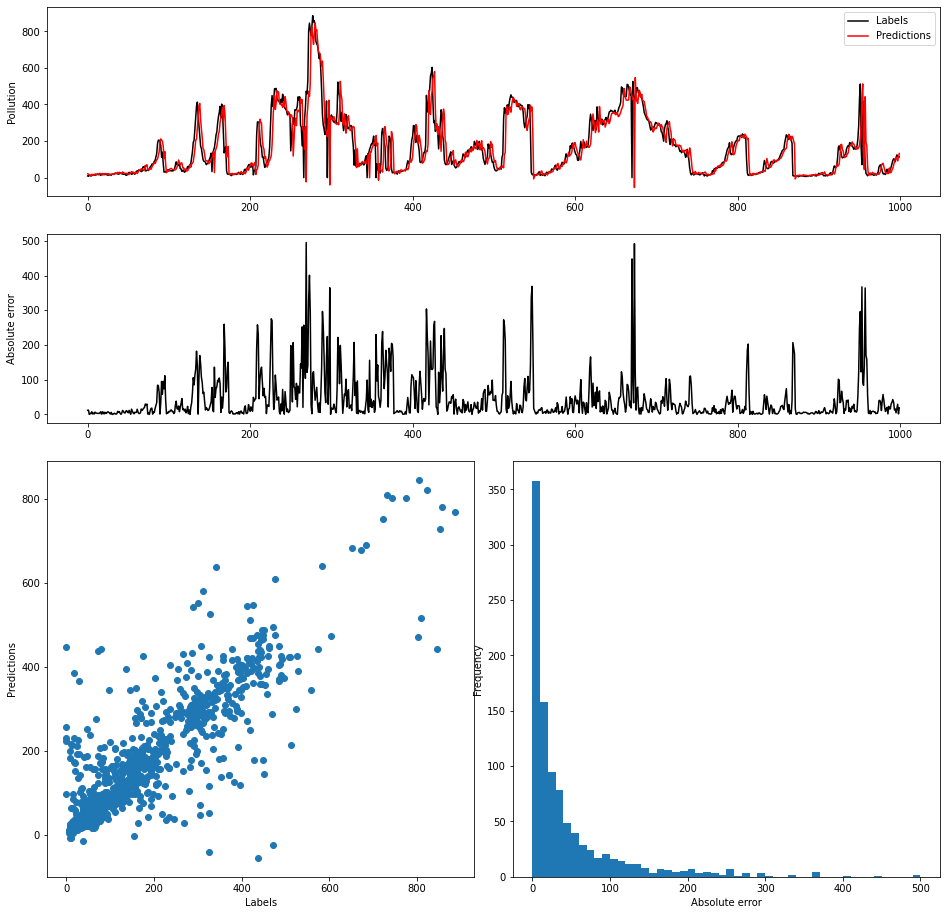

In [44]:
y_train_CNNmodel = CNNmodel.predict(X_train_w)
y_val_CNNmodel = CNNmodel.predict(X_val_w)

mae_train_CNNmodel = mean_absolute_error(r_train_w,y_train_CNNmodel)
mae_val_CNNmodel = mean_absolute_error(r_val_w,y_val_CNNmodel)

print("\"Window pollution\" baseline:\n train mae = ",mae_train_CNNmodel,
      "\n validation mae = ",mae_val_CNNmodel)

print(y_train_CNNmodel.shape)
print(y_val_CNNmodel.shape)

# Visualise first 1000 predictions for validation
PlotResults(r_val_w[:1000],y_val_CNNmodel[:1000,0])